<a href="https://colab.research.google.com/github/smartbin2021/Smart-Bin/blob/main/Senior_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras-ocr

     |████████████████████████████████| 57 kB 5.1 MB/s 
     |████████████████████████████████| 9.5 MB 23.1 MB/s 
     |████████████████████████████████| 868 kB 39.2 MB/s 
     |████████████████████████████████| 123 kB 58.5 MB/s 
     |████████████████████████████████| 50 kB 7.5 MB/s 
  Created wheel for keras-ocr: filename=keras_ocr-0.8.7-py3-none-any.whl size=43749 sha256=795192a3e518174e429bc7c4ff8c53841304941a5dd7b95133646983385252ce
  Stored in directory: /root/.cache/pip/wheels/e4/e4/f3/05528293e01d7fa089343d5a5fd63dd07d79f57103fe9fc159
Successfully built keras-ocr


In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

import keras_ocr
import tensorflow as tf
import tensorflow_hub as hub

 
# show an image
import PIL
from PIL import ImageDraw
from PIL import Image
from numpy import asarray

In [24]:
remove_dict = {ord('['): None,
               ord(']'): None,
               ord('/'): None,
               ord('\\'):None,
               ord('*'): None,
               ord('$'): None,
               ord('&'): None,
               ord('!'): None,
               ord('@'): None,
               ord('#'): None,
               ord('%'): None,
               ord('^'): None,
               ord('('): None,
               ord(')'): None,
               ord('.'): None,
               ord(','): None,
               ord(';'): None,
               ord(':'): None,
               ord('<'): None,
               ord('>'): None,
               ord('?'): None,
               ord('~'): None}

word_dict = {'brand_rec':['pepsi', 'lumiere','gardenia','almaza','nutella','chtoura','puidor','rim','aquafina','johnnie','laziza',
                          'beirut','dollys','sunbay','pril','dimex','poppins','lipton','perrier','walker','aquafina'],
             
             'brand_non_rec':['master','cheetos','ringo','lays','pringles','dolsi','snickers', 'mars', 'kitkat','bounty','flake',
                              'halabi','twix','bubbly','flake','oreo'],

             'brand_limit':['nestle','milka','maccaw','plein','soleil','siblou','americana','alwadi','alakhdar','maxims',
                            'dairy','yamama','aruba'],

             'word_limit':['coffee','cafe','vinegar','kinder','coco','lait','hot','chili','paste'],

             'word_rec_match':['white','red','pops','mate','tomato','life','fish','fillets'],

             'word_nonrec_match':['bueno','orange','melk','frozen','milk','chunky','leo','shrimps','rings'],

             'word_rec':['beer', 'water','sardines','tuna','mayonnaise', 'ketchup','mustard', 'sanitizer','disinfectant','dip','aluminum',
                         'jam','whisky','wine','vodka','flakes','mushrooms','peas','hommus','sauce','scotch','cereal', 'beverage', 'halawa','tea'],

             'word_non_rec':['bag', 'chips','potato','wipes','soup','leo','soup','bar']} 


In [5]:
path = "/content/gdrive/MyDrive/test_images"
#dir_list = [path+'/'+img for img in os.listdir(path) if img.split(".")[-1]=='jpg']
dir_list = [path+'/'+img for img in os.listdir(path)]
print(len(dir_list))
dir_list

10


['/content/gdrive/MyDrive/test_images/image00006.jpeg',
 '/content/gdrive/MyDrive/test_images/image00008.jpeg',
 '/content/gdrive/MyDrive/test_images/image00003.jpeg',
 '/content/gdrive/MyDrive/test_images/image00002.jpeg',
 '/content/gdrive/MyDrive/test_images/image00010.jpeg',
 '/content/gdrive/MyDrive/test_images/image00005.jpeg',
 '/content/gdrive/MyDrive/test_images/image00007.jpeg',
 '/content/gdrive/MyDrive/test_images/image00009.jpeg',
 '/content/gdrive/MyDrive/test_images/image00004.jpeg',
 '/content/gdrive/MyDrive/test_images/20210508_185623.jpg']

In [14]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Looking for /root/.keras-ocr/crnn_kurapan.h5


In [15]:
def process_image_ocr(image_path):
  """
  Takes an image file path and returns a list of the image in 4 different rotations as numpy array.
  """
  images_list = []
  angle = 0
  for rotations in range(4):
    # Read in an image file
    image = Image.open(image_path)
    #Rotate image
    image = image.rotate(angle)
    # Turn the jpeg image into numerical numpy array
    image = asarray(image)
    #Update angle
    angle+=90
    #Append image to images list
    images_list.append(image)
  #Read images using the keras-ocr tool
  #images = [keras_ocr.tools.read(img) for img in images_list]
  return images_list

In [16]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path, custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [17]:
classif_model = load_model('/content/gdrive/MyDrive/20210521-sp2-Cnn_Model__transfer_535 (1).h5')

Loading saved model from: /content/gdrive/MyDrive/20210521-sp2-Cnn_Model__transfer_535 (1).h5


In [18]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value "IMG_SIZE"
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  #Expand dimensions
  image = np.expand_dims(image,axis=0)
  return image

In [19]:
def get_predictions(img_path):
  en_bounds = []
  ar_bounds = []
  en_b = []
  ar_b = []
  #Extracting images from file paths for Keras-OCR and EasyOCR
  images = process_image_ocr(img_path)
  #Extracting english text using keras-ocr
  keras_images = [keras_ocr.tools.read(img) for img in images]
  keras_preds = pipeline.recognize(keras_images)
    
  #Defining empty list which contains the extracted words
  preds = []

  #Transforming keras-ocr bounds nested lists into one list which is preds
  for pred in keras_preds:
    for word in pred:
      preds.append(word[0].lower())
  

  #Remove duplicates from prediction list   
  preds = list(set(preds))
  return preds

In [20]:
preds = get_predictions(dir_list[0])
preds 

['pajueiens',
 't202',
 'great',
 'sinieh',
 'en',
 'szn',
 'guaranteed',
 'oani',
 'isdy',
 'meigaers',
 'nei',
 'soall',
 'his',
 'pnn2',
 'paqueiens',
 'sunser',
 'nziroing',
 's',
 'ringo',
 'tasting',
 'e',
 'paps',
 'chipsi',
 'isdys',
 '1eaid',
 'chipsl',
 'salted']

In [21]:
def predict(img_path):
  #Get predictions from models 
  preds = get_predictions(img_path)

  #See if the words in pred match any of our pre-defined dictionary words
  result = None
  limit_word = None
  for word in preds: 
    if (word in word_dict["brand_rec"]) or (word in word_dict["word_rec"]):
      result = True
      return result, word
    elif (word in word_dict["brand_non_rec"]) or (word in word_dict["word_non_rec"]):
      result = False
      return result, word
  for word in preds:
    if (word in word_dict["brand_limit"]) or (word in word_dict["word_limit"]):
      limit_word = word
      for match in preds:
        if match in word_dict["word_rec_match"]:
          result = True
          word = word + ', ' +match
          return result, word
        elif match in word_dict["word_nonrec_match"]:
          word = word + ', ' +match
          result = False
          return result, word
  classif_pred = classif_model.predict(process_image(img_path, img_size=IMG_SIZE))
  if classif_pred<=0.5:
    result = True
  else: 
    result = False
  limit_word = "Classifier"

  return result, limit_word

In [31]:
def plot_prediction(img_path):
  new_path = img_path.split("/")[-1]
  new_path = new_path.split(".")[0]
  result, word = predict(img_path)
  txt = ""
  # 0 is for recyclable, 1 is for non_recyclable, 2 is for unknown, 3 is for limited
  product_type= None
  if result==True:
    txt = "Recyclable: " + word
    new_path = "/content/gdrive/MyDrive/Smartbin1/recyclable/"+ new_path +"_result.png"
    product_type=0
  elif result==False:
    txt = "Non-recyclable: " + word
    new_path = "/content/gdrive/MyDrive/Smartbin1/non_recyclable/"+ new_path +"_result.png"
    product_type=1
  elif result==None and word!=None:
    txt = "Unknown: "+ word
    new_path = "/content/gdrive/MyDrive/Smartbin1/other/"+ new_path +"_result.png"
    product_type=2
  else:
    txt = "Unknown: No word match"
    new_path = "/content/gdrive/MyDrive/Smartbin1/other/"+ new_path +"_result.png"
    product_type=3
  img = mpimg.imread(img_path)
  imgplot = plt.imshow(img)
  plt.axis('off')
  plt.savefig(new_path, bbox_inches='tight')
  plt.text(0, -20, txt)
  plt.show()
  return product_type

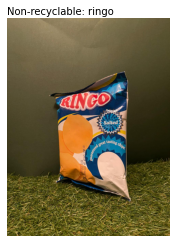

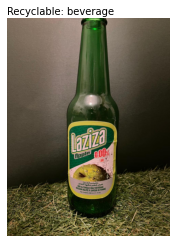

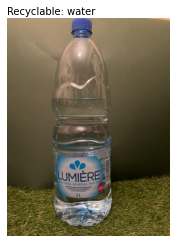

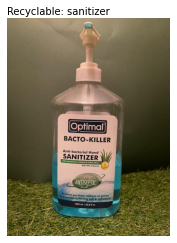

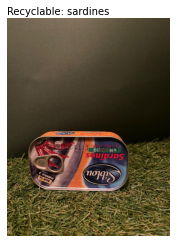

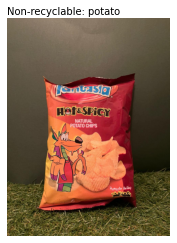

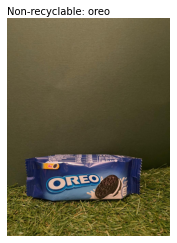

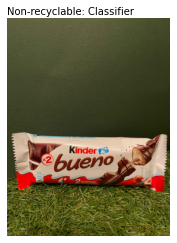

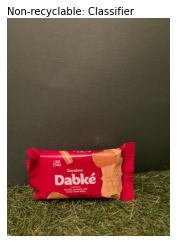

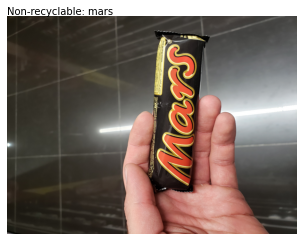

Recyclable:  4
Non-Recyclable:  6
Unknown:  0
Limited:  0


In [33]:
rec_count = 0
non_rec_count = 0
unknown_count = 0
limited_count = 0
for img_path in dir_list:
  product_type=plot_prediction(img_path)
  if product_type==0:
    rec_count +=1
  elif product_type==1:
    non_rec_count +=1
  elif product_type==2:
    unknown_count +=1
  else:
    limited_count +=1

print("Recyclable: ", rec_count)
print("Non-Recyclable: ", non_rec_count)